In [1]:
import os
import random
from copy import deepcopy

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch_geometric

import network
from convert import parse_dump
from lammps_scripts import ElasticScript, LJSimulationStandalone
from simulation import (
    CompressionSimulation,
    LJSimulation,
    TemperatureRange,
    gen_sim_data,
    run_lammps_calc,
)
from utils import (
    add_edges_LJ,
    draw_graph,
    draw_network,
    get_correct_edge_attr,
    inject_noise,
    randomize_LJ,
    recalc_bond,
    recalc_bonds,
)



In [124]:
round(0.656545, 1)

0.7

In [2]:
def calc_p_ratio_box(simulation: list, index: int = -1) -> float:
    """Calculates Poisson ratio from the box data

    Parameters
    ----------
    simulation : list[Data]
        list of torch_geometric `Data` objects
    Returns
    -------
    float
        Poisson ratio
    """
    return -(simulation[index].box.y - simulation[0].box.y) / (
        simulation[index].box.x - simulation[0].box.x
    )

def get_elastic_data(log_file: str) -> tuple[float]:
    with open(log_file, encoding="utf8") as file:
        content = file.readlines()
        p_ratio = float(content[-2].strip().split(" ")[3])
        shear_modulus = float(content[-4].strip().split(" ")[4])
        bulk_modulus = float(content[-8].strip().split(" ")[3])
        return (p_ratio, bulk_modulus, shear_modulus)
    
def compute_angle(vec1, vec2) -> torch.Tensor:
    return torch.rad2deg(torch.arccos(torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))))

def compute_angles_graph(graph) -> torch.Tensor:
    nodes = graph.x
    edges = graph.edge_index.T

    adj_list = {}
    for edge in edges:
        try:
            adj_list[edge[0].item()].append(edge[1].item())
        except KeyError:
            adj_list[edge[0].item()] = [edge[1].item()]
        try:
            adj_list[edge[1].item()].append(edge[0].item())
        except KeyError:
            adj_list[edge[1].item()] = [edge[0].item()]

    angles = []
    for center_node in adj_list:
        center_position = nodes[center_node]
        neighbour_nodes = adj_list[center_node]
        vecs = []
        for n in neighbour_nodes:
            neighbour_position = nodes[n]
            vec = center_position - neighbour_position
            vec[0] = torch.where(abs(vec[0]) >= graph.box.x // 2,
                vec[0] - graph.box.x*torch.sign(vec[0]),
                vec[0]
            )
            
            vec[1] = torch.where(abs(vec[1]) >= graph.box.y // 2,
                vec[1] - graph.box.y*torch.sign(vec[1]),
                vec[1]
            )
            vecs.append(vec)

        for i in range(len(vecs)):
            for j in range(i+1, len(vecs)):
                value = compute_angle(vecs[i], vecs[j])
                angles.append(value)
    
    return torch.tensor(angles)

In [87]:
from convert import assemble_data, network_from_data


def get_correct_edge_vec(original_graph):
    # Extract source and target node coordinates
    original_source_nodes = original_graph.x[original_graph.edge_index[0]][:, 0:2]
    original_target_nodes = original_graph.x[original_graph.edge_index[1]][:, 0:2]

    # Extract box dimensions
    box = original_graph.box

    # Compute naive edge vectors
    naive_edge_vectors = original_source_nodes - original_target_nodes

    # Compute corrections for x-coordinates
    adjust_x = torch.abs(naive_edge_vectors[:, 0]) > (box.x / 2)
    correction_x = torch.sign(original_source_nodes[:, 0]) * (
        box.x / 2
        - torch.abs(original_source_nodes[:, 0])
        + box.x / 2
        - torch.abs(original_target_nodes[:, 0])
    )
    fixed_target_nodes_x = torch.where(
        adjust_x,
        original_source_nodes[:, 0] + correction_x,
        original_target_nodes[:, 0],
    )

    # Compute corrections for y-coordinates
    adjust_y = torch.abs(naive_edge_vectors[:, 1]) > (box.y / 2)
    correction_y = torch.sign(original_source_nodes[:, 1]) * (
        box.y / 2
        - torch.abs(original_source_nodes[:, 1])
        + box.y / 2
        - torch.abs(original_target_nodes[:, 1])
    )
    fixed_target_nodes_y = torch.where(
        adjust_y,
        original_source_nodes[:, 1] + correction_y,
        original_target_nodes[:, 1],
    )

    # Combine the corrected coordinates
    fixed_target_nodes = torch.column_stack(
        [fixed_target_nodes_x, fixed_target_nodes_y]
    )

    # Compute the fixed edge vectors
    fixed_edge_vectors = fixed_target_nodes - original_source_nodes
    return fixed_edge_vectors

inp_net = network.Network.from_atoms(
    "/home/sergey/work/simulator_data_gen/one_over_l/103_4/3/coord.dat",
    include_default_masses=1e6,
)

init_graph = assemble_data(inp_net.atoms, inp_net.bonds, inp_net.box)
init_graph.edge_attr = get_correct_edge_attr(init_graph)

new_net = network_from_data(init_graph, box=init_graph.box)


# Randomly remove edges and get auxetics

In [122]:
import shutil


calc_dir = "/home/sergey/work/simulator_data_gen/random_edge_removal"
os.makedirs(calc_dir, exist_ok=True)
inp_net = network.Network.from_atoms(
    "/home/sergey/work/simulator_data_gen/one_over_l/103_4/3/coord.dat",
    include_default_masses=1e6,
)
diameters = [atom.diameter for atom in inp_net.atoms]
inp_net.set_angle_coeff(0.0)
for bond in inp_net.bonds:
    bond.bond_coefficient = 1/bond.length

for d in os.listdir(calc_dir):
    if os.path.isdir(d):
        shutil.rmtree(os.path.join(calc_dir, d))

inp_net.write_to_file(os.path.join(calc_dir, 'network.lmp'))
elastic_sim = ElasticScript('network.lmp')
elastic_sim.write_to_file(calc_dir)
run_lammps_calc(calc_dir, input_file='in.elastic')
p_ratio, bulk, shear = get_elastic_data(os.path.join(calc_dir, 'log.lammps'))
print(f"Original P: {p_ratio:.3f}")

fraction_nodes = 0.3
fraction_edges = 0.3

ps = []
for i in range(100):
    new_net = deepcopy(inp_net)
    graph = assemble_data(new_net.atoms, new_net.bonds, box=new_net.box)

    # shift beads     
    nodes_to_shift = [random.randint(0, graph.x.shape[0]-1) for i in range(int(fraction_nodes*graph.x.shape[0]))]
    orig = graph.x[nodes_to_shift]
    orig_edges = graph.edge_attr
    graph.x[nodes_to_shift] += torch.rand_like(graph.x[nodes_to_shift]) * 0.3
    # print(graph.x[nodes_to_shift] - orig)
    graph.edge_attr = get_correct_edge_attr(graph)
    new_net = network_from_data(graph, box=graph.box)
    new_net.masses = {1:1e6}
    # new_net.set_angle_coeff(0.0)
    for bond in new_net.bonds:
        bond.bond_coefficient = 1/bond.length

    # remove bonds
    bonds_to_remove = random.sample(new_net.bonds, int(len(new_net.bonds)*fraction_edges))
    new_net.bonds = list(filter(lambda b: b not in bonds_to_remove, new_net.bonds))
    new_net.header.bond_types = len(new_net.bonds)
    new_net.header.bonds = len(new_net.bonds)

    localpath = os.path.join(calc_dir, str(i))
    os.makedirs(localpath, exist_ok=True)
    new_net.write_to_file(os.path.join(localpath, 'network.lmp'))
    elastic_sim = ElasticScript('network.lmp')
    elastic_sim.write_to_file(localpath)
    run_lammps_calc(localpath, 'in.elastic')
    p_ratio, bulk, shear = get_elastic_data(os.path.join(localpath, 'log.lammps'))
    print(p_ratio)
    ps.append(p_ratio)



Original P: 0.380
0.435314856331741
0.425387521380782
0.356382183986108
0.454135820184046
0.465444111542676
0.238036843973459
-0.0523320604329355
0.657206137494317
0.414635505729574
0.511745560885613
0.609173972119561
0.185610115868915
0.412706542083494
0.595899695925376
0.17850215353136
0.857936216329006
0.263714407306017
0.0453062048707233
0.108435373306587
0.245360029151901
0.313095910307875
0.477662248611221
0.511167943642878
0.469488600756573
-0.466291339047238
0.850214086327119
0.607455769144605
0.605988875514983
0.12080407943925
0.2715534641061
0.351471646856205
0.451051594548401
0.581399623644636
0.63874807347776
0.552828647784651
0.643230768456729
0.815307478080411
0.933932882958306
0.268360669519238
0.208102792155398
0.405056319823238
0.112849758495552
0.54057590437936
-0.0112020640756997
0.1366616021058
-0.216099986024143
0.427220792663841
0.111682720830338
0.755969161155269
0.781323859196697
-0.0573575428224409
-0.0817211220184744
0.186843492874068
0.0507403855521826
0.5746

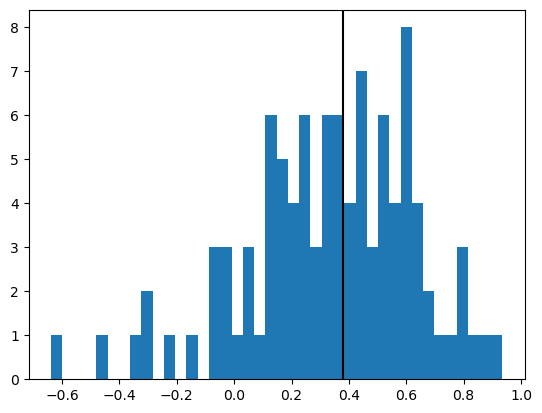

In [123]:
plt.hist(ps, bins=40)
plt.axvline(0.380, c='black')
plt.show()

In [ ]:
from utils import load_data

data = load_data("../gnn/NN_Simulator/data/1500+2340_dePablo_networks_OOL_5steps_for_pos.pt")

In [ ]:
from convert import network_from_data

uncorrelated_subset = list(filter(lambda s: calc_p_ratio_box(s) < 0.0, data))
print(f"Uncorr: {len(uncorrelated_subset)}")
correlated_subset = list(filter(lambda s: calc_p_ratio_box(s) > 0.0, data))
print(f"Corr: {len(correlated_subset)}")

# main_dir = "/home/sergey/work/simulator_data_gen/noise_dePablo"
# os.makedirs(main_dir, exist_ok=True)
# noised_subset = []
# for index, sim in enumerate(correlated_subset):
#     graph = sim[0]
#     graph.x = graph.x + torch.randn_like(graph.x)*0.4
#     graph.edge_attr = get_correct_edge_attr(graph)

#     net = network_from_data(graph)
#     local_path = os.path.join(main_dir, str(index))
#     os.makedirs(local_path)
#     net.write_to_file(os.path.join(local_path, "network.lmp"))

#     # elastic_sim = ElasticScript("network.lmp")
#     # elastic_sim.write_to_file(local_path)
#     # run_lammps_calc(local_path, 'in.elastic')
#     # p_ratio, bulk, shear = get_elastic_data(os.path.join(local_path, "log.lammps"))
#     # new_ps.append(p_ratio)

#     comp_sim = CompressionSimulation(
#         box_size=graph.box.x,
#         network_filename='network.lmp',
#         strain=0.005,
#         temperature_range=TemperatureRange(1e-7, 1e-7, 10)
#     )
#     comp_sim.write_to_file(local_path)
#     run_lammps_calc(local_path, 'in.deformation')
#     new_sim = parse_dump(os.path.join(local_path, "dump.lammpstrj"), net, node_features='coord')
#     noised_subset.append(new_sim[:5])


In [ ]:
dist_mean = [torch.mean(sim[0].edge_attr[:, -2]) for sim in uncorrelated_subset]
dist_std = [torch.std(sim[0].edge_attr[:, -2]) for sim in uncorrelated_subset]
ang_std = [torch.std(compute_angles_graph(sim[0])) for sim in uncorrelated_subset]
ang_mean = [torch.mean(compute_angles_graph(sim[0])) for sim in uncorrelated_subset]
size = [sim[0].x.shape[0] for sim in uncorrelated_subset]
ps = [calc_p_ratio_box(sim) for sim in uncorrelated_subset]
ps_short = [calc_p_ratio_box(sim[:2]) for sim in uncorrelated_subset]

c_dist_mean = [torch.mean(sim[0].edge_attr[:, -2]) for sim in correlated_subset]
c_dist_std = [torch.std(sim[0].edge_attr[:, -2]) for sim in correlated_subset]
c_ang_std = [torch.std(compute_angles_graph(sim[0])) for sim in correlated_subset]
c_ang_mean = [torch.mean(compute_angles_graph(sim[0])) for sim in correlated_subset]
c_size = [sim[0].x.shape[0] for sim in correlated_subset]
c_ps = [calc_p_ratio_box(sim) for sim in correlated_subset]
c_ps_short = [calc_p_ratio_box(sim[:2]) for sim in correlated_subset]

# n_dist_mean = [torch.mean(sim[0].edge_attr[:, -2]) for sim in noised_subset]
# n_dist_std = [torch.std(sim[0].edge_attr[:, -2]) for sim in noised_subset]
# n_ang_std = [torch.std(compute_angles_graph(sim[0])) for sim in noised_subset]
# n_ang_mean = [torch.mean(compute_angles_graph(sim[0])) for sim in noised_subset]
# n_size = [sim[0].x.shape[0] for sim in noised_subset]
# n_ps = [calc_p_ratio_box(sim) for sim in noised_subset]
# n_ps_short = [calc_p_ratio_box(sim[:2]) for sim in noised_subset]

In [ ]:
torch.save(uncorrelated_subset, "../gnn/NN_Simulator/data/data_uncorr_1700_dePablo_Pleq0.0_OOL.pt")

In [ ]:
plt.hist(ps)
plt.hist(ps_short, alpha=0.5)
plt.show()

In [ ]:
import pandas as pd

df_for_corr = pd.DataFrame((dist_mean, dist_std, ang_mean, ang_std, size, ps, ps_short))
df_for_corr = df_for_corr.T
df_for_corr.columns = ['dist_mean', 'dist_std', 'ang_mean', 'ang_std', 'size', 'P_full', 'P_2nd_step']
# Compute the correlation matrix
correlation_matrix = df_for_corr.corr()
# Plot the correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better spacing
cax = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
# Add color bar to the heatmap
fig.colorbar(cax, ax=ax)
# Annotate each cell with the correlation coefficient
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
# # Set axis labels and title
ax.set_xticks(np.arange(correlation_matrix.shape[1]))
ax.set_yticks(np.arange(correlation_matrix.shape[0]))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha="right")  # Rotate x-axis labels and adjust alignment
ax.set_yticklabels(correlation_matrix.index)
# # Increase space between ticks to avoid overlap
plt.tight_layout(pad=5)  # Adjust padding between the plot elements
# # Show the plot
plt.show()

In [ ]:
import pandas as pd

# df_for_corr = pd.DataFrame[['p_error', 'p_error_delta', 'y_error_std', 'y_mean_error']]
df_for_corr = pd.DataFrame((c_dist_mean, c_dist_std, c_ang_mean, c_ang_std, c_size, c_ps, c_ps_short))
df_for_corr = df_for_corr.T
df_for_corr.columns = ['dist_mean', 'dist_std', 'ang_mean', 'ang_std', 'size', 'P_full', 'P_2nd_step']
# Compute the correlation matrix
correlation_matrix = df_for_corr.corr()
correlation_matrix
# # Plot the correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better spacing
cax = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
# # Add color bar to the heatmap
fig.colorbar(cax, ax=ax)
# # Annotate each cell with the correlation coefficient
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
# # Set axis labels and title
ax.set_xticks(np.arange(correlation_matrix.shape[1]))
ax.set_yticks(np.arange(correlation_matrix.shape[0]))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha="right")  # Rotate x-axis labels and adjust alignment
ax.set_yticklabels(correlation_matrix.index)
# # Increase space between ticks to avoid overlap
plt.tight_layout(pad=5)  # Adjust padding between the plot elements
# # Show the plot
plt.show()

In [ ]:
import pandas as pd

# df_for_corr = pd.DataFrame[['p_error', 'p_error_delta', 'y_error_std', 'y_mean_error']]
df_for_corr = pd.DataFrame((n_dist_mean, n_dist_std, n_ang_mean, n_ang_std, n_size, n_ps, n_ps_short))
df_for_corr = df_for_corr.T
df_for_corr.columns = ['dist_mean', 'dist_std', 'ang_mean', 'ang_std', 'size', 'P_full', 'P_2nd_step']
# Compute the correlation matrix
correlation_matrix = df_for_corr.corr()
correlation_matrix
# # Plot the correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size for better spacing
cax = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
# # Add color bar to the heatmap
fig.colorbar(cax, ax=ax)
# # Annotate each cell with the correlation coefficient
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
# # Set axis labels and title
ax.set_xticks(np.arange(correlation_matrix.shape[1]))
ax.set_yticks(np.arange(correlation_matrix.shape[0]))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha="right")  # Rotate x-axis labels and adjust alignment
ax.set_yticklabels(correlation_matrix.index)
# # Increase space between ticks to avoid overlap
plt.tight_layout(pad=5)  # Adjust padding between the plot elements
# # Show the plot
plt.show()

## LAMMPS strain speed

In [ ]:
main_dir = "/home/sergey/work/simulator_data_gen/lammps_strain_speed_dePablo"
os.makedirs(main_dir)
# step_size = 0.01
# lj_sim = LJSimulation(
#     n_atoms=100,
#     n_atom_types=4,
#     atom_sizes=[0.8, 1.0, 1.2, 1.4],
#     box_dim=[-40, 40, -40, 40, -1, 1],
#     temperature_range=TemperatureRange(0.0005, 0.0001, 10.0),
#     n_steps=30_000,
# )
# lj_sim.write_to_file(main_dir)
# run_lammps_calc(main_dir, input_file='lammps.in')

net = network.Network.from_data_file(input_file="dePablo_network.lmp", include_default_masses=1e6)
for bond in net.bonds:
    bond.bond_coefficient = 1/bond.length
net.set_angle_coeff(0.00)
net.write_to_file(os.path.join(main_dir, "network.lmp"))


sims = {}
for rate in (1e-6, 1e-5, 1e-4, 1e-3):
    subdir = os.path.join(main_dir, f'{float(rate)}')
    os.makedirs(subdir)
    net.write_to_file(os.path.join(subdir, "network.lmp"))

    comp_sim = CompressionSimulation(
        strain_direction='x',
        box_size=net.box.x,
        network_filename='network.lmp',
        dt=0.01,
        strain=0.01,
        strain_rate=rate,
        desired_step_size=0.001,
        random_seed=True,
        temperature_range=TemperatureRange(1e-7, 1e-7, 10.0)
    )
    comp_sim.write_to_file(subdir)
    run_lammps_calc(subdir, "in.deformation")

    sims[rate] = parse_dump(
        os.path.join(subdir, "dump.lammpstrj"),
        net,
        node_features='coord'
    )

In [ ]:
sims.keys()

In [ ]:
for size, sim in sims.items():
    if sim:
        try:
            plt.scatter(size, calc_p_ratio_box(sim), label=f'Strain rate: {size:.1e}')
        except ZeroDivisionError:
            print(f"Size {size} too much")
            continue

plt.xticks(list(sims.keys()))
plt.axvline(1e-5, linestyle='--', color='red', linewidth=1.0, label='default strain rate')
plt.xscale('log')
plt.xlabel("Strain rate")
plt.ylabel("$\\nu$")
plt.legend()
plt.show()

## LAMMPS High T Random seed

In [ ]:
main_dir = "/home/sergey/work/simulator_data_gen/lammps_random_seed"
step_size = 0.01
lj_sim = LJSimulation(
    n_atoms=100,
    n_atom_types=4,
    atom_sizes=[0.8, 1.0, 1.2, 1.4],
    box_dim=[-40, 40, -40, 40, -1, 1],
    temperature_range=TemperatureRange(0.0005, 0.0001, 10.0),
    n_steps=30_000,
)
lj_sim.write_to_file(main_dir)
run_lammps_calc(main_dir, input_file='lammps.in')

net = network.Network.from_atoms(input_file=os.path.join(main_dir, "coord.dat"), include_default_masses=1e6)
for bond in net.bonds:
    bond.bond_coefficient = 1/bond.length
net.set_angle_coeff(0.00)
net.write_to_file(os.path.join(main_dir, "network.lmp"))


for i in range(5):
    subdir = os.path.join(main_dir, f'{i+1}')
    os.makedirs(subdir)
    net.write_to_file(os.path.join(subdir, "network.lmp"))

    comp_sim = CompressionSimulation(
        strain_direction='x',
        box_size=net.box.x,
        network_filename='network.lmp',
        dt=step_size,
        strain=0.03,
        strain_rate=1e-5,
        random_seed=True,
        temperature_range=TemperatureRange(1e-5, 1e-5, 10.0)
    )
    comp_sim.write_to_file(subdir)
    run_lammps_calc(subdir, "in.deformation")

In [ ]:
from convert import parse_dump

random_sims = []
for i in range(5):
    subdir = os.path.join(main_dir, f'{i+1}')
    random_sims.append(parse_dump(
        os.path.join(subdir, "dump.lammpstrj"),
        net,
        node_features='coord',
        skip=1
        )
    )

In [ ]:
torch.save(random_sims, "/home/sergey/work/gnn/NN_Simulator/data/random_sims.pt")

## LAMMPS check T vs P

In [ ]:
import pickle

main_dir = "/home/sergey/work/simulator_data_gen/lammps_t_over_p"
data_dir = "/home/sergey/work/simulator_data_gen/one_over_l"
steps_to_check = (1, 15, 30, 45)
ts_to_check = (1e-7, 1e-3)
paths = []
for size_dir in os.listdir(data_dir):
    if size_dir != "data_generation.log":
        for network_dir in os.listdir(os.path.join(data_dir, size_dir)):
            for step in steps_to_check:
                path = os.path.join(data_dir, size_dir, network_dir, f"network{step}.lmp")
                paths.append(path)

for i in range(50):
    path = random.sample(paths, 1)[0]
    print(f"Step {i+1}: {path}")
    net = network.Network.from_data_file(
        input_file=path,
        include_default_masses=1e6,
        include_angles=True,
        include_dihedrals=False
    )
    for bond in net.bonds:
        bond.bond_coefficient = 1/bond.length
    net.set_angle_coeff(0.00)

    for t in ts_to_check:
        comp_path = os.path.join(main_dir, str(i+1), str(t))
        os.makedirs(comp_path)
        net.write_to_file(os.path.join(comp_path, "network.lmp"))
        comp_sim = CompressionSimulation(
            strain_direction='x',
            box_size=net.box.x,
            network_filename='network.lmp',
            dt=0.01,
            strain=0.01,
            strain_rate=1e-5,
            random_seed=True,
            temperature_range=TemperatureRange(t, t, 10.0)
        )
        comp_sim.write_to_file(comp_path)
        run_lammps_calc(comp_path, "in.deformation")


In [ ]:
data_lowT = []
data_highT = []

for i in range(50):
    sim_lowT = parse_dump(
        f"/home/sergey/work/simulator_data_gen/lammps_t_over_p/{i+1}/{1e-3}/dump.lammpstrj",
        network.Network.from_data_file(f"/home/sergey/work/simulator_data_gen/lammps_t_over_p/{i+1}/{1e-3}/network.lmp", include_default_masses=1e6),
        node_features='coord'
    )
    data_lowT.append(sim_lowT)
    sim_highT = parse_dump(
        f"/home/sergey/work/simulator_data_gen/lammps_t_over_p/{i+1}/{1e-7}/dump.lammpstrj",
        network.Network.from_data_file(f"/home/sergey/work/simulator_data_gen/lammps_t_over_p/{i+1}/{1e-7}/network.lmp", include_default_masses=1e6),
        node_features='coord'
    )
    data_highT.append(sim_highT)


In [ ]:
ps_high = [calc_p_ratio_box(sim) for sim in data_highT]
ps_low = [calc_p_ratio_box(sim) for sim in data_lowT]

In [ ]:
plt.scatter(ps_high, ps_low)
plt.xlabel("$T=10^{-3}$")
plt.ylabel("$T=10^{-7}$")
plt.title("P ratio vs Temperature")
plt.show()

## LAMMPS big step

In [ ]:
main_dir = "/home/sergey/work/simulator_data_gen/lammps_big_step"
os.makedirs(main_dir)
# step_size = 0.5
# lj_sim = LJSimulation(
#     n_atoms=150,
#     n_atom_types=4,
#     atom_sizes=[0.8, 1.0, 1.2, 1.4],
#     box_dim=[-40, 40, -40, 40, -1, 1],
#     temperature_range=TemperatureRange(0.0005, 0.0001, 10.0),
#     n_steps=30_000,
# )
# lj_sim.write_to_file(main_dir)
# run_lammps_calc(main_dir, input_file='lammps.in')

net = network.Network.from_data_file(input_file="/home/sergey/work/simulator_data_gen/dePablo_network.lmp", include_default_masses=1e6)
# net = network.Network.from_atoms(input_file=os.path.join(main_dir, "coord.dat"), include_default_masses=1e6)
net.set_angle_coeff(0.00)
net.write_to_file(os.path.join(main_dir, "network.lmp"))

sims = {}
for step_size in [0.005, 0.01, 0.02, 0.04, 0.08, 0.16]:
    subdir = os.path.join(main_dir, f'{float(step_size)}')
    os.makedirs(subdir, exist_ok=True)
    net.write_to_file(os.path.join(subdir, 'network.lmp'))
    comp_sim = CompressionSimulation(
        strain_direction='x',
        box_size=net.box.x,
        network_filename='network.lmp',
        dt=step_size,
        strain=0.03,
        strain_rate=1e-5,
        temperature_range=TemperatureRange(1e-7, 1e-7, 100)
    )
    comp_sim.write_to_file(subdir)
    run_lammps_calc(subdir, "in.deformation")
    sims[step_size] = parse_dump(
            os.path.join(subdir, "dump.lammpstrj"),
            net,
            node_features='coord'
        )

In [ ]:
def calc_p_ratio_box(simulation: list, index: int = -1) -> float:
    """Calculates Poisson ratio from the box data

    Parameters
    ----------
    simulation : list[Data]
        list of torch_geometric `Data` objects
    Returns
    -------
    float
        Poisson ratio
    """
    return -(simulation[index].box.y - simulation[0].box.y) / (
        simulation[index].box.x - simulation[0].box.x
    )

In [ ]:
for size, sim in sims.items():
    if sim and size < 0.16:
        plt.scatter(size, calc_p_ratio_box(sim, 50), label=f'Step size: {size}')

plt.legend()
plt.xlabel("Step size")
plt.ylabel("$\\nu$")
plt.show()

In [ ]:


sim = parse_dump(os.path.join(main_dir, "dump.lammpstrj"), net, node_features='coord')
print(len(sim))

In [ ]:
draw_network(net, periodic_edges=False)

## Rest

In [ ]:
for stepsize in (0.1, 0.01, 0.001, 1e-4, 0.002, 0.003):
    chunks_path = f"/home/sergey/work/simulator_data_gen/data/binary/data_dePablo_OOL_step_size_{stepsize}"
    
    data = []
    for chunk_name in os.listdir(chunks_path):
        chunk = torch.load(os.path.join(chunks_path, chunk_name), weights_only=False)
        data.append(chunk)
    
    print(f"Length data {stepsize} = {len(data)}")
    torch.save(data, f"/home/sergey/work/gnn/NN_Simulator/data/dePablo_networks_OOL_stepsize_{stepsize}.pt")


In [ ]:
raw_data_path = "/home/sergey/work/simulator_data_gen/data/binary/data_dePablo_OOL_0.05strain"
count = 0
for size_dir in os.listdir(raw_data_path):
    if size_dir != "data_generation.log":
        for net_dir in os.listdir(os.path.join(raw_data_path, size_dir)):
            for comp_dir in os.listdir(os.path.join(raw_data_path, size_dir, net_dir)):
                if comp_dir.startswith("comp_"): #and 'one_over_l' in comp_dir:
                    count += 1

print(count)

In [ ]:
name_suffix = "SR=1e-06"
path = f"/home/sergey/work/simulator_data_gen/data/binary/data_dePablo_OOL_{name_suffix}"
chunks = []
for chunk_name in os.listdir(path):
    chunk = torch.load(os.path.join(path, chunk_name), weights_only=False)
    chunks.append(chunk)

len(chunks)

In [ ]:
torch.save(chunks, f"/home/sergey/work/gnn/NN_Simulator/data/dePablo_networks_OOL_{name_suffix}.pt")

In [ ]:
os.chdir("/home/sergey/work/simulator_data_gen")
data_1  = torch.load("validation_Ttimes1.pt", weights_only=False)
data_10  = torch.load("validation_Ttimes10.pt", weights_only=False)
data_100  = torch.load("validation_Ttimes100.pt", weights_only=False)
data_1000  = torch.load("validation_Ttimes1000.pt", weights_only=False)
data_10000  = torch.load("validation_Ttimes10000.pt", weights_only=False)

In [ ]:
calc_dir = "/home/sergey/work/simulator_data_gen/scaling" # work

for i in range(5):
    loc_dir = os.path.join(calc_dir, str(i))
    os.makedirs(loc_dir)
    lj_sim = LJSimulation(
        n_atoms=120,
        atom_sizes=[16, 14, 12, 10],
        n_atom_types=4,
        box_dim=[-300, 300, -300, 300, -1, 1],
        temperature_range=TemperatureRange(0.0005, 0.0001, 10.0),
        n_steps=30_000,
    )
    lj_sim.write_to_file(loc_dir)
    run_lammps_calc(loc_dir, input_file='lammps.in')


In [ ]:
skip = 1
data = []
for i in sizes:
    sim = []
    dump_file = os.path.join(calc_dir, str(i), "dump.lammpstrj")

    with open(dump_file, "r", encoding="utf8") as f:
            content = f.readlines()

    timesteps: list[int] = []
    for index, line in enumerate(content):
        if "ITEM: TIMESTEP" in line:
            timesteps.append(index)

    for i in range(0, len(timesteps) - 1, skip):
        timestep_data = content[timesteps[i] : timesteps[i + 1]]
        atoms = [list(map(lambda x: float(x), line.split()[1:3])) for line in timestep_data[9:]]
        graph = torch_geometric.data.Data(x=torch.tensor(atoms))
        graph.box = network.Box(-30, 30, -30, 30, -0.1, 0.1)
        graph = add_edges_LJ(graph, r=2.0)
        graph.edge_attr = torch.ones_like(graph.edge_attr)
        sim.append(graph)
    data.append(sim)
    # datasets[edge_radius] = data

In [ ]:
torch.save(data, "/home/sergey/work/simulator_data_gen/diff_size.pt")

In [ ]:
for key, value in datasets.items():
    torch.save(value, f"/home/sergey/work/simulator_data_gen/LJ_data_r{key}.pt")

In [ ]:
from convert import parse_dump

ord_data = []
for i in sizes:
    loc_dir = os.path.join(calc_dir, str(i))
    ord_network = network.Network.from_data_file(
        os.path.join(loc_dir, f"network{i}.lmp"),
        include_default_masses=1e6,
    )
    sim = parse_dump(
        os.path.join(loc_dir, "dump.lammpstrj"),
        ord_network,
        node_features="coord"
    )

    ord_data.append(sim)

ord_data

In [ ]:
torch.save(data, "/home/sergey/work/gnn/NN_Simulator/LJ_data.pt")

In [ ]:
def draw_network(
    net: network.Network,
    edges: bool = True,
    periodic_edges: bool = True,
    box: bool = False,
    node_color: str = "skyblue",
    standalone: bool = True,
    node_size: float = 20,
    figure_scale: float = 3,
):
    if standalone:
        plt.figure(figsize=(8, 8))
    G = nx.Graph()
    # Add nodes
    for atom in net.atoms:
        G.add_node(atom.atom_id)

    pos = {atom.atom_id: (float(atom.y), float(atom.x)) for atom in net.atoms}

    # Add edges
    if edges:
        edge_index = [(bond.atom1.atom_id, bond.atom2.atom_id) for bond in net.bonds]
        naive_edge_lengths = [bond.atom1.dist(bond.atom2) for bond in net.bonds]
        for edge, length in zip(edge_index, naive_edge_lengths):
            if periodic_edges:
                G.add_edge(edge[0], edge[1])
            else:
                if length < net.box.x // 2:
                    G.add_edge(edge[0], edge[1])

    if box:
        B = nx.Graph()
        box_corners = [
            (net.box.x1, net.box.y1),
            (net.box.x1, net.box.y2),
            (net.box.x2, net.box.y1),
            (net.box.x2, net.box.y2),
        ]
        box_edges = [
            [box_corners[0], box_corners[1]],
            [box_corners[1], box_corners[2]],
            [box_corners[2], box_corners[3]],
            [box_corners[3], box_corners[0]],
        ]

        for corner, edge in zip(box_corners, box_edges):
            B.add_node(corner)
            B.add_edge(edge[0], edge[1])
        b_pos = {}
        b_pos[box_corners[0]] = (net.box.x1, net.box.y2)
        b_pos[box_corners[1]] = (net.box.x2, net.box.y2)
        b_pos[box_corners[2]] = (net.box.x2, net.box.y1)
        b_pos[box_corners[3]] = (net.box.x1, net.box.y1)

        nx.draw_networkx(B, b_pos, with_labels=False, node_color="black", node_size=1)

    nx.draw_networkx(
        G,
        pos,
        with_labels=False,
        node_color=node_color,
        node_size=node_size,
        font_size=10,
    )
    # nx.draw_networkx(G, with_labels=False, node_color=node_color, node_size=node_size, font_size=10)
    if standalone:
        plt.show()


In [ ]:
example = network.Network.from_data_file("data/raw/noised_prund/140_4/network_data/2/network.lmp")
draw_network(example, periodic_edges=False)

In [ ]:
from utils import load_data

data = load_data('noisy_networks.pt')